In [ ]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [1]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

C:\Users\76745\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

In [3]:
data_path='data/'
result_path='results/'
adata0=scv.read('DG_bin.h5ad', cache=True)

In [ ]:
gene_arr=adata0.var.index.values
X_pca=adata0.obsm['X_pca']
X_umap=adata0.obsm['X_umap']
cell_vpt=adata0.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
Xs=adata0.layers['Ms']#adata.X.A#
X_pca.shape

In [ ]:
#-------data preprocessing
k_nei=10
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

In [16]:
row =np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()

col=adata.uns['neighbors']['indices'].flatten()

w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])

adj_val=np.ones(col.shape)

A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

W_mat=csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [21]:
epochs = 1000
nsamples = 5
learning_rate = 1e-3
seed = 0
# n_workers = 0          ### num_workers数目设置
K = 4# !!!!!!!!!! K should be large enough
#     checkpoint_path = args.checkpoint
#     checkpoints_path = args.checkpoints
#     dataset_path = args.dataset6

if seed is not None:
    reset_seeds(seed)

A=A_mat
# X=Xs
X=Xs/np.mean(np.abs(Xs),axis=0)
# X=adata.X.A
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=cell_vpt

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
#train_nodes, val_nodes = train_test_split(n, train_ratio=0.75)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = 256       ## 稍微大一些，用于寻找 latent dimension
encoder = Encoder(X.shape[1], L)

In [22]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs ## // n_workers  #不可为0
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
    # num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

0 tensor(3.5250e+11, grad_fn=<DivBackward0>)
50 tensor(5.4646e+09, grad_fn=<DivBackward0>)
100 tensor(4.8936e+09, grad_fn=<DivBackward0>)
150 tensor(4.6323e+09, grad_fn=<DivBackward0>)
200 tensor(4.5138e+09, grad_fn=<DivBackward0>)
250 tensor(4.4905e+09, grad_fn=<DivBackward0>)
300 tensor(4.4080e+09, grad_fn=<DivBackward0>)
350 tensor(4.3949e+09, grad_fn=<DivBackward0>)
400 tensor(4.3829e+09, grad_fn=<DivBackward0>)
450 tensor(4.3702e+09, grad_fn=<DivBackward0>)
500 tensor(4.3786e+09, grad_fn=<DivBackward0>)
550 tensor(4.3937e+09, grad_fn=<DivBackward0>)
600 tensor(4.3584e+09, grad_fn=<DivBackward0>)
650 tensor(4.3606e+09, grad_fn=<DivBackward0>)
700 tensor(4.3159e+09, grad_fn=<DivBackward0>)
750 tensor(4.3503e+09, grad_fn=<DivBackward0>)
800 tensor(4.3492e+09, grad_fn=<DivBackward0>)
850 tensor(4.3307e+09, grad_fn=<DivBackward0>)
900 tensor(4.3308e+09, grad_fn=<DivBackward0>)
950 tensor(4.3052e+09, grad_fn=<DivBackward0>)


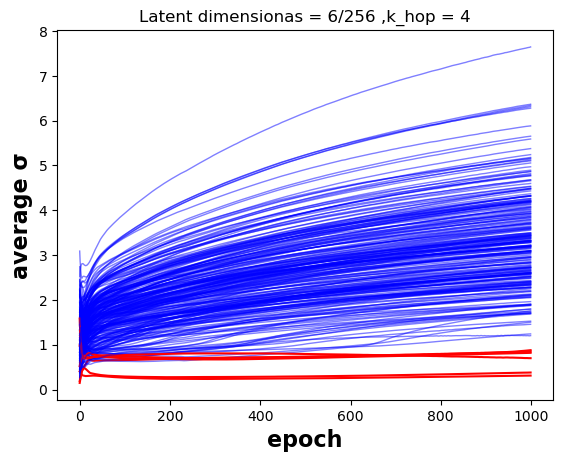

6
[43, 200, 204, 207, 236, 237]


In [23]:
sigma_step = []
latent_dim = []
non_inc = 0

for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    
    #mu, sigma = encoder.forward(data[0][0])
    mu, sigma = encoder(train_data.X)
    sigma_aver = torch.sum(sigma,dim = 0)/n

    sigma_step.append(sigma_aver.detach().numpy())
    if batch_idx% 50 == 0:        
        print(batch_idx,loss)
    loss.backward()
    optimizer.step()
    
sigma_step = np.array(sigma_step)

plt.figure()

plt.xlabel('epoch',fontsize=16,fontweight='bold')
plt.ylabel('average σ',fontsize=16,fontweight='bold')


for i in range(L):
    
    if sigma_step[-1,i] < 1:
        non_inc += 1
        latent_dim.append(i)
        plt.plot(range(epochs),sigma_step[:,i], color='red')
    elif sigma_step[epochs//2,i] < sigma_step[0,i]:
        plt.plot(range(epochs),sigma_step[:,i], color='y')
    else:
        plt.plot(range(epochs),sigma_step[:,i], color='blue',alpha = 0.5,lw = 1)

plt.figure(dpi=600)
plt.title('Latent dimensionas = {non_inc}/{L} ,k_hop = {K}'.format(non_inc = non_inc,K = K,L = L))
plt.savefig('result/k_nei = {k_nei}&k_hop = {K}&L = {L}.png'.format(k_nei = k_nei,K = K,L = L),dpi = 300)
plt.show()
print(non_inc)
print(latent_dim)

In [ ]:
np.save('results/latent_dim', non_inc)